
You're working as a sports journalist at a major online sports media company, specializing in soccer analysis and reporting. You've been watching both men's and women's international soccer matches for a number of years, and your gut instinct tells you that more goals are scored in women's international football matches than men's. This would make an interesting investigative article that your subscribers are bound to love, but you'll need to perform a valid statistical hypothesis test to be sure!

While scoping this project, you acknowledge that the sport has changed a lot over the years, and performances likely vary a lot depending on the tournament, so you decide to limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since `2002-01-01`.

You create two datasets containing the results of every official men's and women's international football match since the 19th century, which you scraped from a reliable online source. This data is stored in two CSV files: `women_results.csv` and `men_results.csv`.

The question you are trying to determine the answer to is:

> Are more goals scored in women's international soccer matches than men's?

You assume a **10% significance level**, and use the following null and alternative hypotheses:

$H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.

$H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import pingouin
from scipy.stats import mannwhitneyu

# Load men's and women's datasets
men = pd.read_csv("men_results.csv")
women = pd.read_csv("women_results.csv")


In [2]:
# Inspect the datasets
print("Men's dataset overview:")
print(men.info())
print(men.head())

print("\nWomen's dataset overview:")
print(women.info())
print(women.head())

Men's dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44353 entries, 0 to 44352
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  44353 non-null  int64 
 1   date        44353 non-null  object
 2   home_team   44353 non-null  object
 3   away_team   44353 non-null  object
 4   home_score  44353 non-null  int64 
 5   away_score  44353 non-null  int64 
 6   tournament  44353 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.4+ MB
None
   Unnamed: 0        date home_team  ... home_score  away_score  tournament
0           0  1872-11-30  Scotland  ...          0           0    Friendly
1           1  1873-03-08   England  ...          4           2    Friendly
2           2  1874-03-07  Scotland  ...          2           1    Friendly
3           3  1875-03-06   England  ...          2           2    Friendly
4           4  1876-03-04  Scotland  ...          3           0    Friend

In [3]:
# Summary statistics for goals
print("\nMen's goals summary statistics:")
print(men[['home_score', 'away_score']].describe())

print("\nWomen's goals summary statistics:")
print(women[['home_score', 'away_score']].describe())


Men's goals summary statistics:
         home_score    away_score
count  44353.000000  44353.000000
mean       1.740559      1.178793
std        1.748722      1.394580
min        0.000000      0.000000
25%        1.000000      0.000000
50%        1.000000      1.000000
75%        2.000000      2.000000
max       31.000000     21.000000

Women's goals summary statistics:
        home_score   away_score
count  4884.000000  4884.000000
mean      2.272727     1.431409
std       2.736377     1.974651
min       0.000000     0.000000
25%       0.000000     0.000000
50%       1.000000     1.000000
75%       3.000000     2.000000
max      24.000000    24.000000


The higher average and variability of scores in women’s matches suggest that the total goals per match in women’s soccer might be higher overall. This aligns with the hypothesis but requires formal testing.
The distributions of goals might be positively skewed, especially for women's matches, given the higher mean compared to the median.

Differences in scoring variability highlight the need for robust statistical tests, as assumptions of normality and equal variances may not hold.

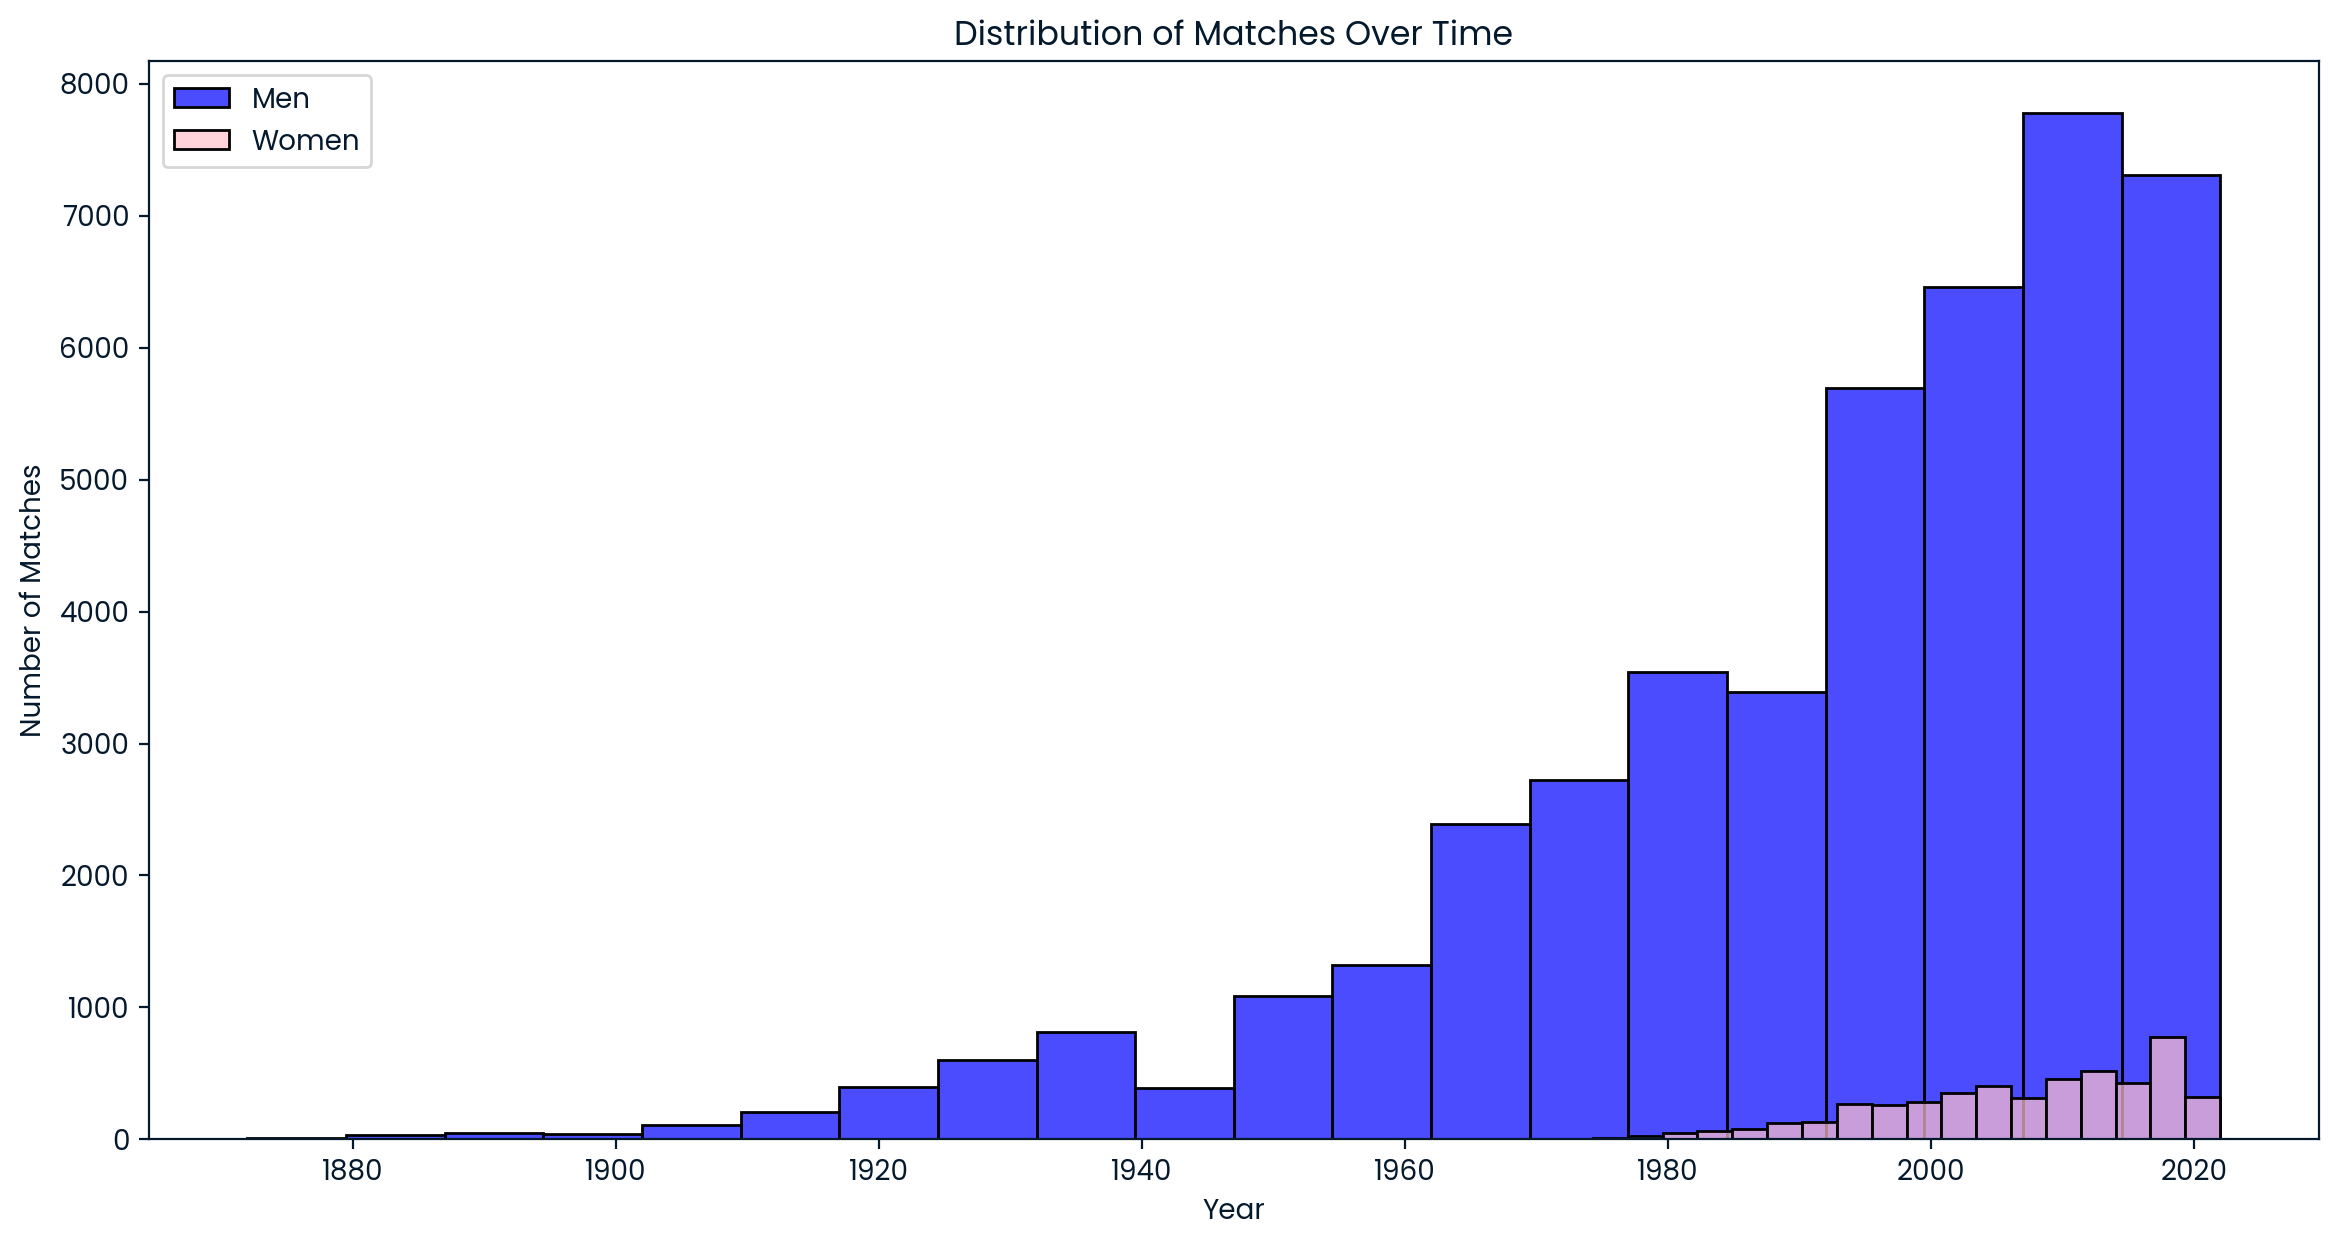

In [5]:
import seaborn as sns
# Matches over time
men['date'] = pd.to_datetime(men['date'])
women['date'] = pd.to_datetime(women['date'])

men['year'] = men['date'].dt.year
women['year'] = women['date'].dt.year

plt.figure(figsize=(14, 7))
sns.histplot(men['year'], bins=20, kde=False, label='Men', color='blue', alpha=0.7)
sns.histplot(women['year'], bins=20, kde=False, label='Women', color='pink', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Number of Matches')
plt.title('Distribution of Matches Over Time')
plt.legend()
plt.show()

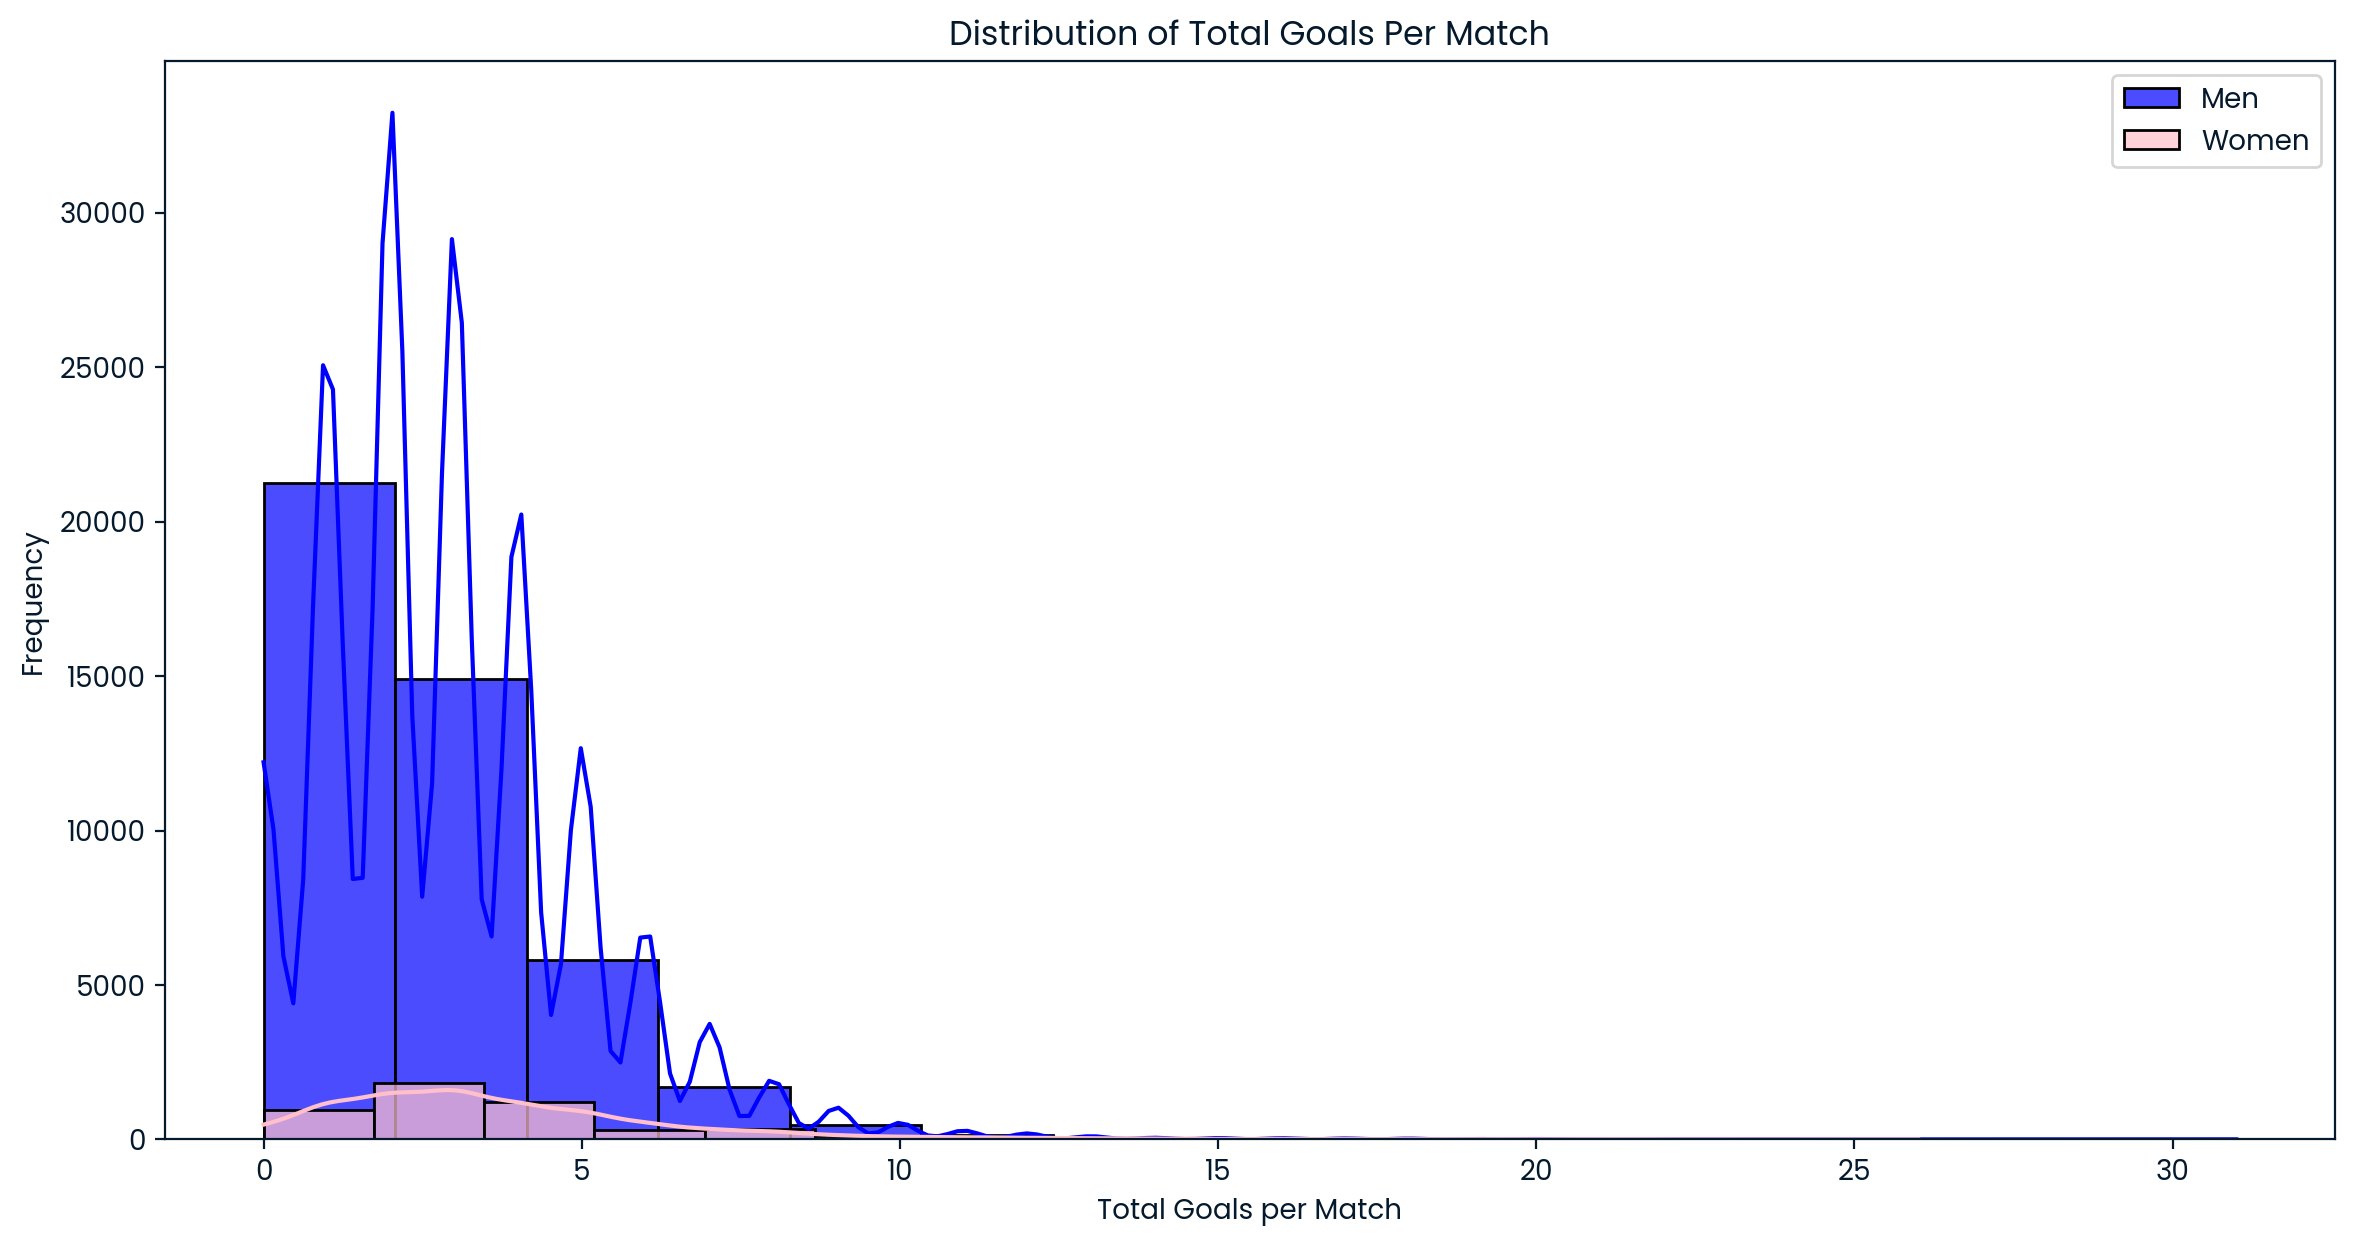

In [6]:
# Total goals per match
men['total_goals'] = men['home_score'] + men['away_score']
women['total_goals'] = women['home_score'] + women['away_score']

plt.figure(figsize=(14, 7))
sns.histplot(men['total_goals'], bins=15, kde=True, label='Men', color='blue', alpha=0.7)
sns.histplot(women['total_goals'], bins=15, kde=True, label='Women', color='pink', alpha=0.7)
plt.xlabel('Total Goals per Match')
plt.ylabel('Frequency')
plt.title('Distribution of Total Goals Per Match')
plt.legend()
plt.show()

In [7]:
# Top participating teams
men_teams = pd.concat([men['home_team'], men['away_team']])
women_teams = pd.concat([women['home_team'], women['away_team']])

print("\nTop 10 participating teams in men's matches:")
print(men_teams.value_counts().head(10))

print("\nTop 10 participating teams in women's matches:")
print(women_teams.value_counts().head(10))


Top 10 participating teams in men's matches:
Sweden         1053
England        1049
Brazil         1021
Argentina      1018
Germany         986
Hungary         966
Mexico          935
Uruguay         919
South Korea     905
France          880
dtype: int64

Top 10 participating teams in women's matches:
United States    381
Norway           319
Sweden           316
Germany          288
China PR         286
Denmark          271
Italy            226
Finland          219
France           212
England          209
dtype: int64


Women’s soccer data has fewer matches, which could impact the robustness of statistical tests.

Dominant teams in women’s soccer may contribute disproportionately to the high-scoring games.

The datasets to include only FIFA World Cup matches played after January 1, 2002, and creates new columns to facilitate analysis.

In [8]:

# Filter the data for the time range and tournament
men["date"] = pd.to_datetime(men["date"])
men_subset = men[(men["date"] > "2002-01-01") & (men["tournament"].isin(["FIFA World Cup"]))]
women["date"] = pd.to_datetime(women["date"])
women_subset = women[(women["date"] > "2002-01-01") & (women["tournament"].isin(["FIFA World Cup"]))]

# Create group and goals_scored columns
men_subset["group"] = "men"
women_subset["group"] = "women"
men_subset["goals_scored"] = men_subset["home_score"] + men_subset["away_score"]
women_subset["goals_scored"] = women_subset["home_score"] + women_subset["away_score"]


In [12]:
combined_data = pd.concat([men_subset, women_subset], ignore_index=True)
print(combined_data.groupby("group")["goals_scored"].describe())


       count      mean       std  min  25%  50%  75%   max
group                                                     
men    384.0  2.513021  1.652544  0.0  1.0  2.0  3.0   8.0
women  200.0  2.980000  2.022387  0.0  2.0  3.0  4.0  13.0


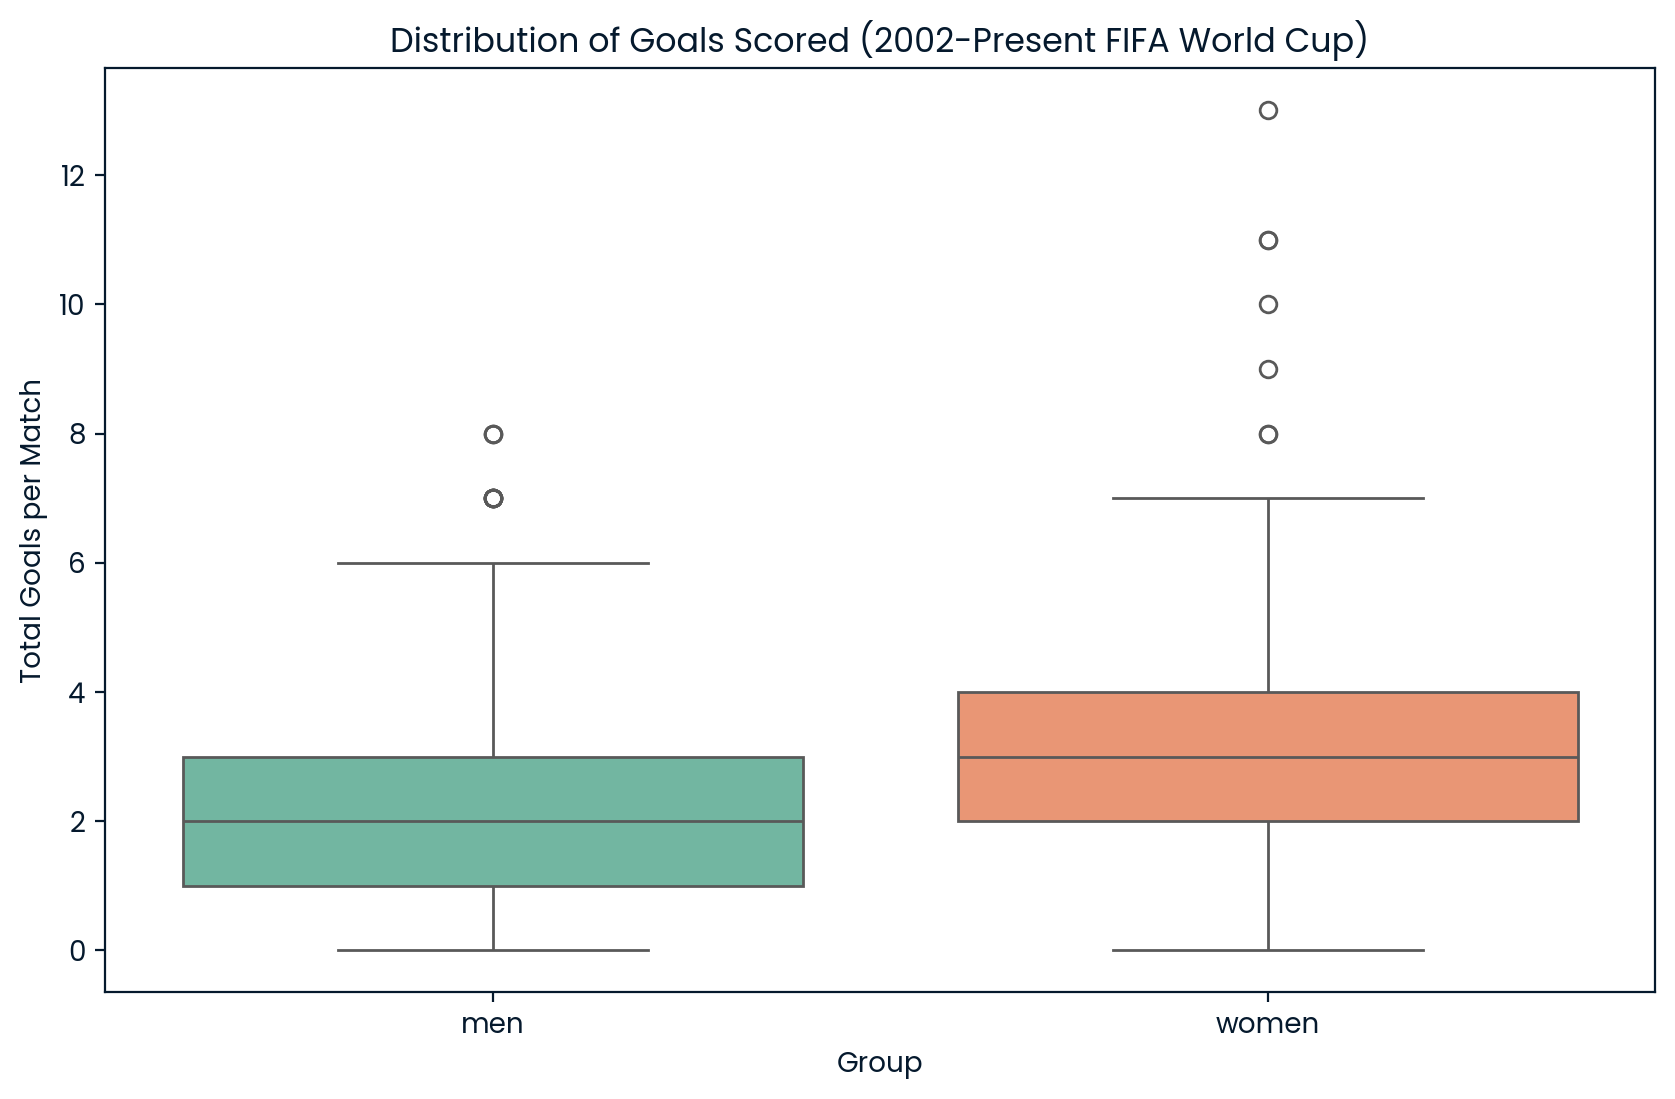

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data, x="group", y="goals_scored", palette="Set2")
plt.title("Distribution of Goals Scored (2002-Present FIFA World Cup)")
plt.xlabel("Group")
plt.ylabel("Total Goals per Match")
plt.show()


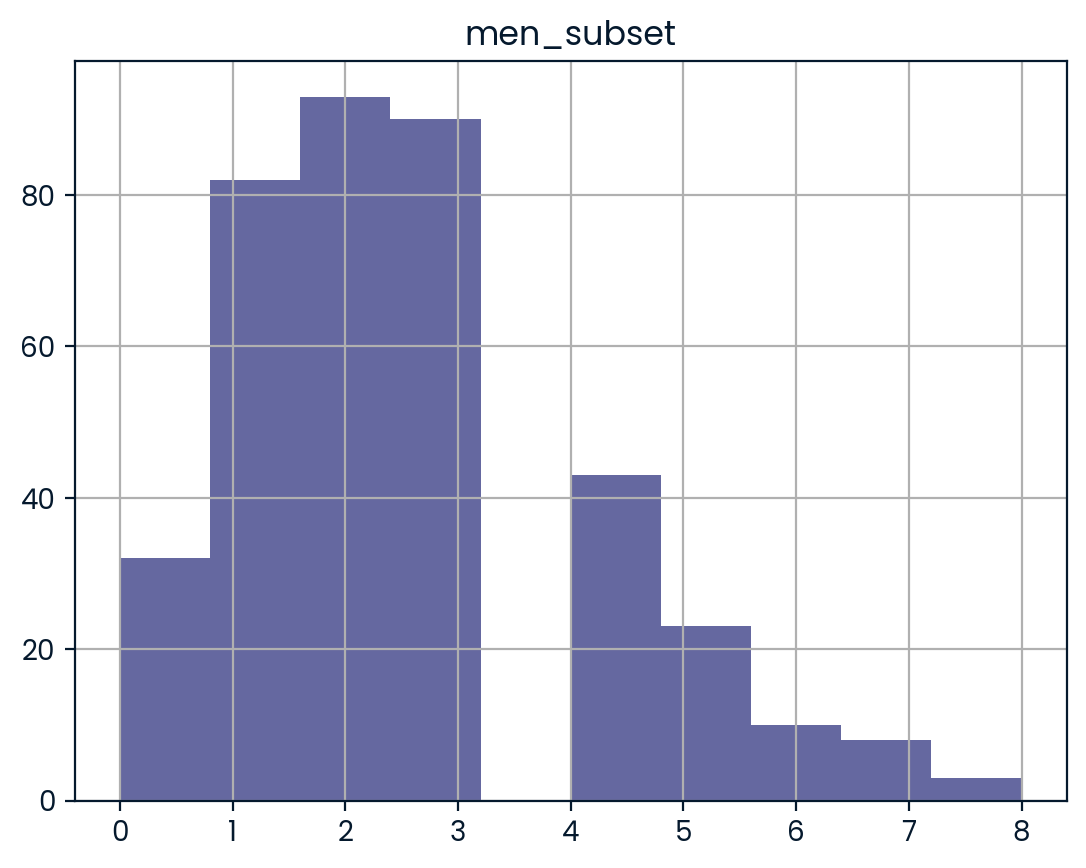

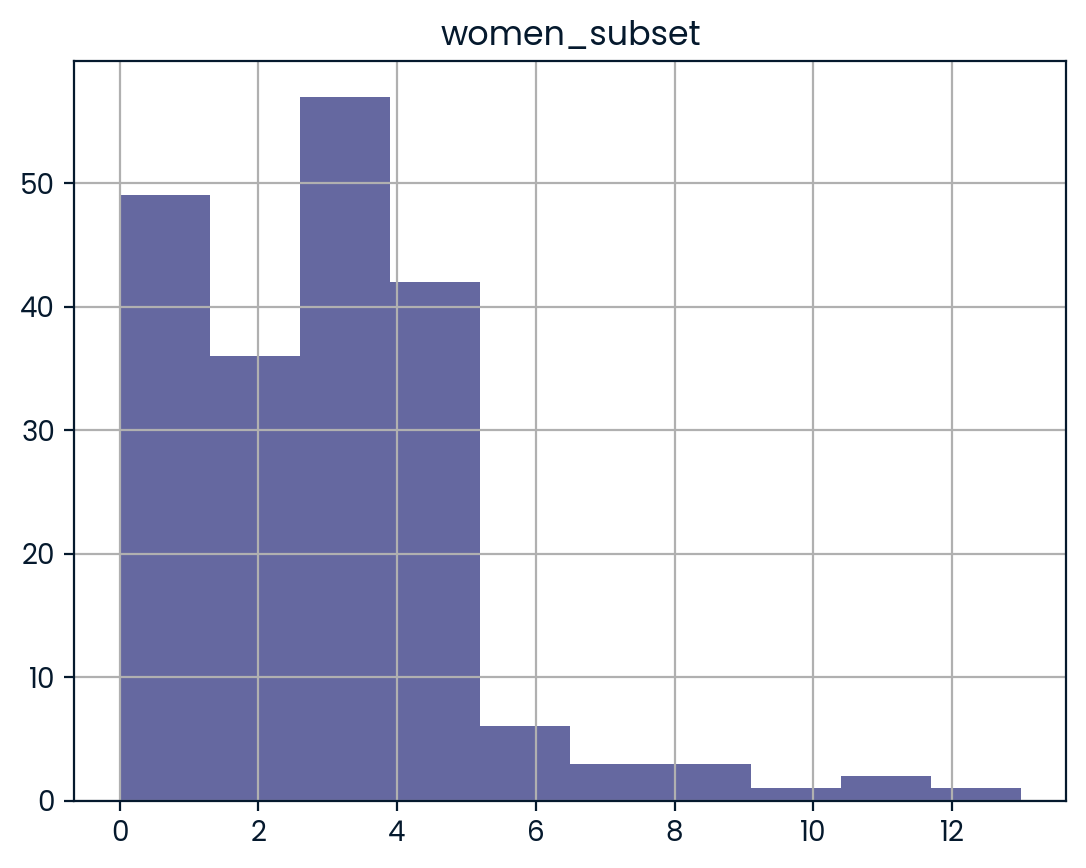

<Figure size 640x480 with 0 Axes>

In [14]:
# Determine normality using histograms
men_subset["goals_scored"].hist()
plt.title('men_subset')
plt.show()
plt.clf()
women_subset["goals_scored"].hist()
plt.title('women_subset')
plt.show()
plt.clf()

Goals scored is not normally distributed, so use Wilcoxon-Mann-Whitney test of two groups

In [25]:

# Combine women's and men's data and calculate goals scored in each match
both = pd.concat([women_subset, men_subset], axis=0, ignore_index=True)

# Transform the data for the pingouin Mann-Whitney U t-test/Wilcoxon-Mann-Whitney test
both_subset = both[["goals_scored", "group"]]
both_subset_wide = both_subset.pivot(columns="group", values="goals_scored")

# Perform right-tailed Wilcoxon-Mann-Whitney test with pingouin
results_pg = pingouin.mwu(x=both_subset_wide["women"],
                          y=both_subset_wide["men"],
                          alternative="greater")
print (results_pg)



       U-val alternative     p-val       RBC      CLES
MWU  43273.0     greater  0.005107 -0.126901  0.563451


In [26]:
# Alternative SciPy solution: Perform right-tailed Wilcoxon-Mann-Whitney test with scipy
results_scipy = mannwhitneyu(x=women_subset["goals_scored"],
                             y=men_subset["goals_scored"],
                             alternative="greater")
print (results_scipy)


MannwhitneyuResult(statistic=43273.0, pvalue=0.005106609825443641)


To interpret the results and determine the outcome of the hypothesis test, I need to compare the extracted p-value with my significance level (0.01). If the p-value is less than 0.01, I can reject the null hypothesis, suggesting that more goals are scored in women's matches.

In [18]:
# Extract p-value as a float
p_val = results_pg["p-val"].values[0]
# Determine hypothesis test result using sig. level
if p_val <= 0.01:
    result = "reject"
else:
    result = "fail to reject"

result_dict = {"p_val": p_val, "result": result}
print(result_dict)

{'p_val': 0.005106609825443641, 'result': 'reject'}


Since the p-value (0.0051) is less than the significance level of 0.01, we reject the null hypothesis.

This provides statistical evidence to support the alternative hypothesis: more goals are scored in women’s international soccer matches than in men's (at the 1% significance level).

Use histograms and density plots to show the distribution of goals scored in men's and women's games.

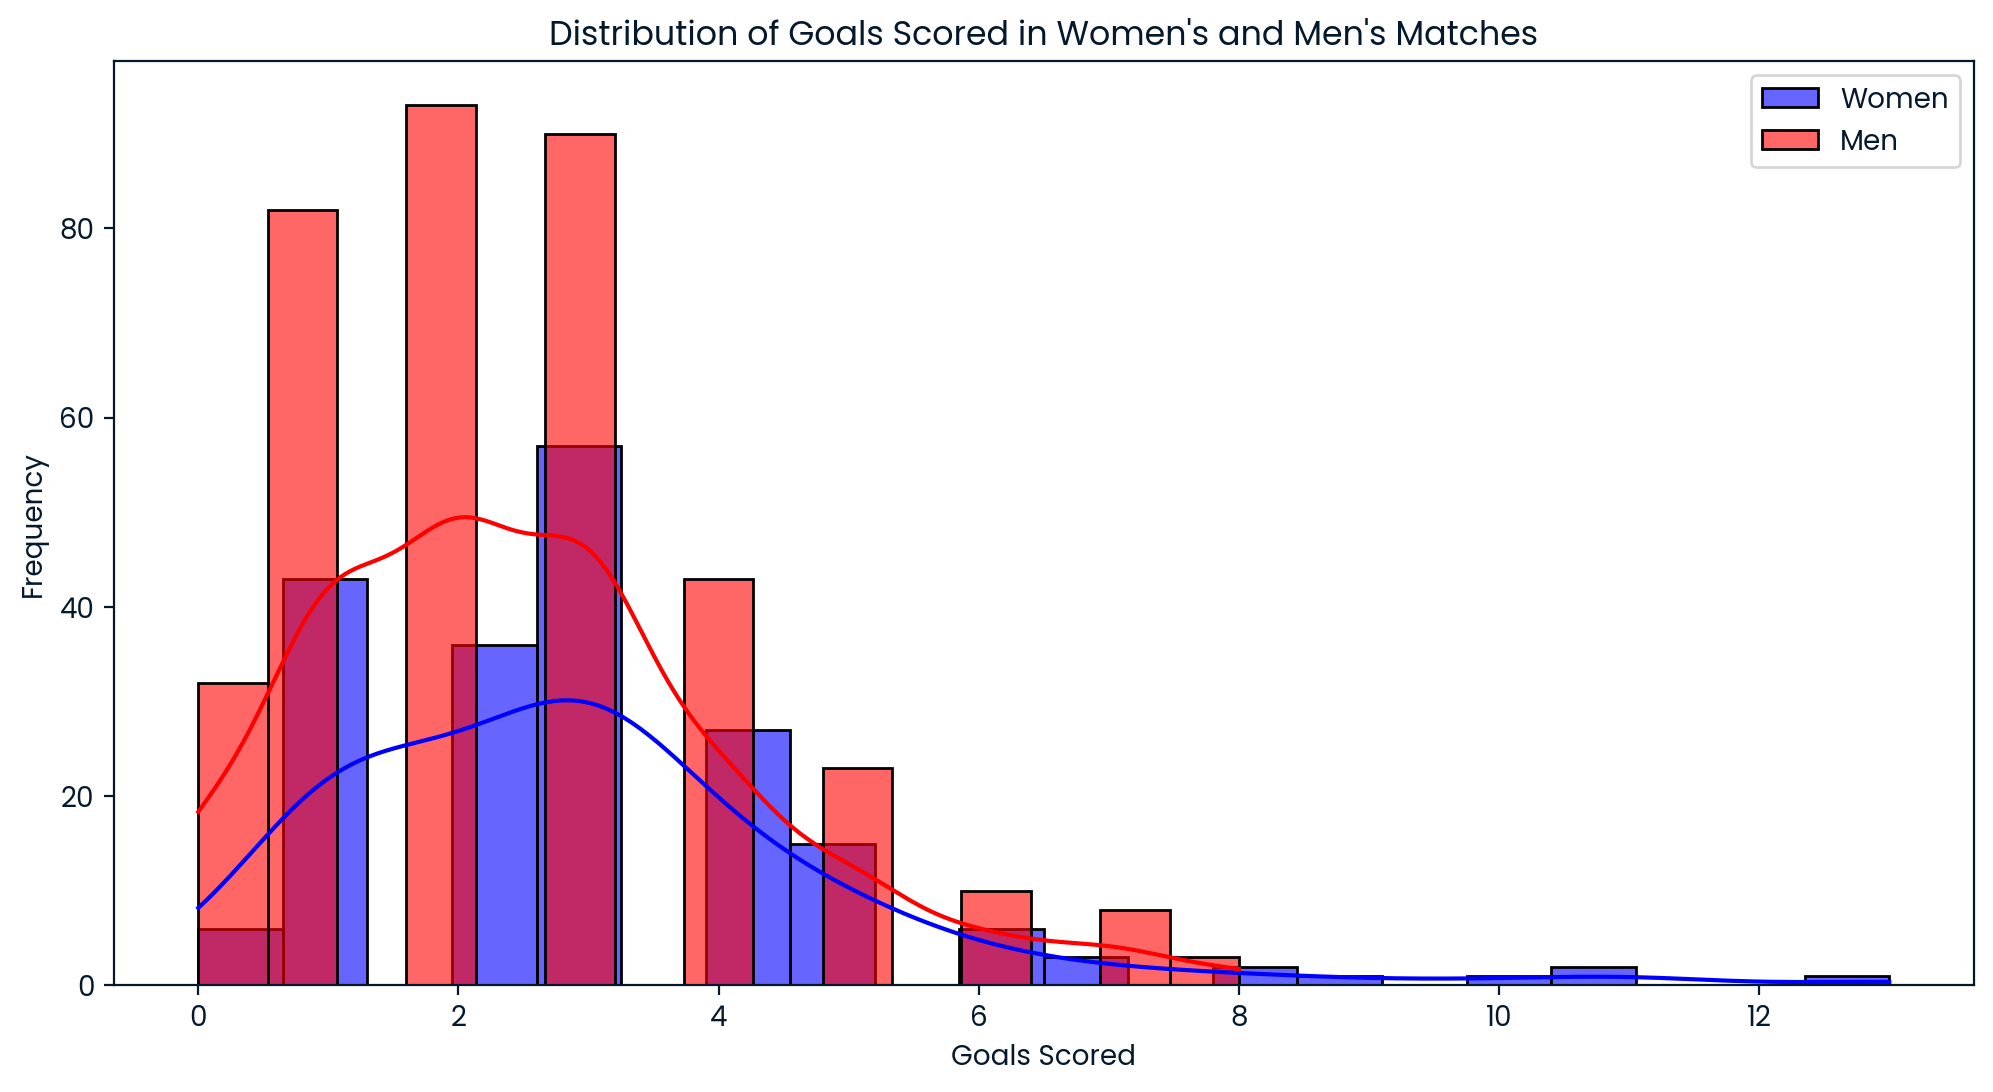

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.histplot(women_subset['goals_scored'], kde=True, color="blue", label="Women", alpha=0.6)
sns.histplot(men_subset['goals_scored'], kde=True, color="red", label="Men", alpha=0.6)
plt.legend()
plt.title('Distribution of Goals Scored in Women\'s and Men\'s Matches')
plt.xlabel('Goals Scored')
plt.ylabel('Frequency')
plt.show()


Match Outcome by Tournament:

Investigate how the match outcomes vary by tournament or by year.

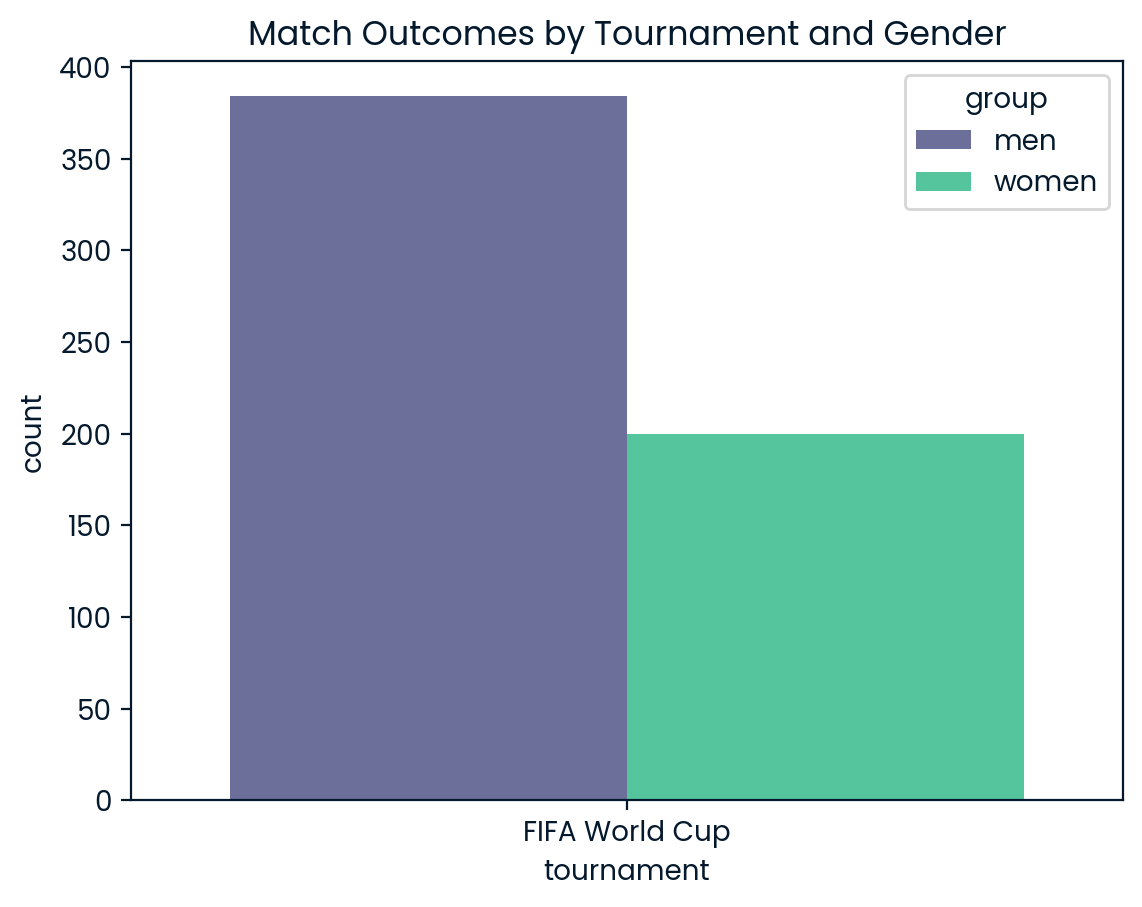

In [21]:
sns.countplot(data=combined_data, x='tournament', hue='group')
plt.title('Match Outcomes by Tournament and Gender')
plt.show()


Use a bar plot to display the average number of goals scored by the top 10 teams in each group.

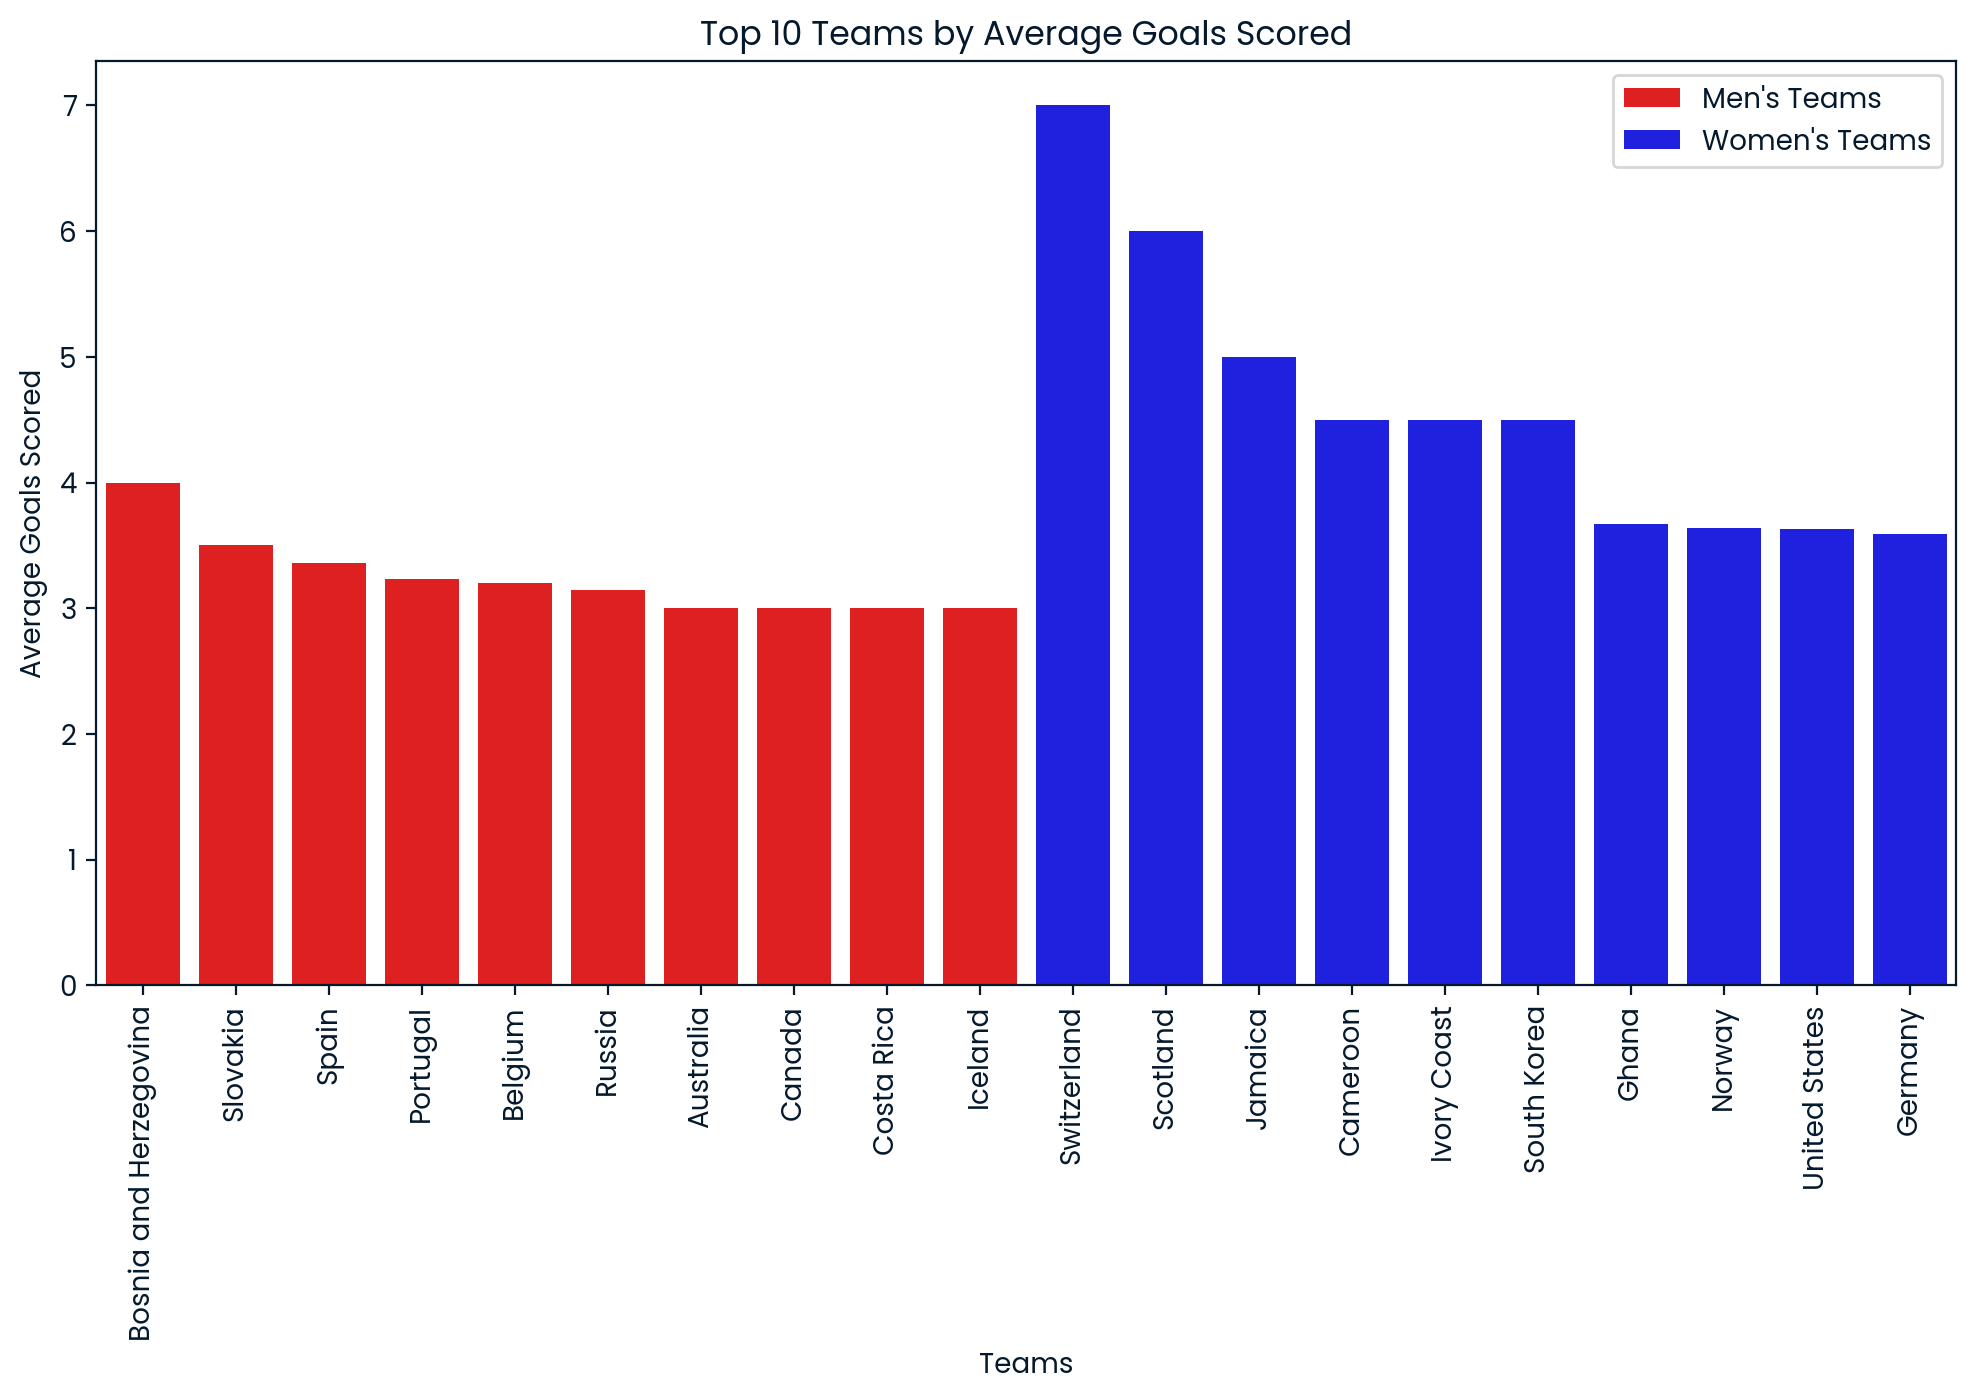

In [22]:
top_teams_men = men_subset.groupby('home_team')['goals_scored'].mean().nlargest(10)
top_teams_women = women_subset.groupby('home_team')['goals_scored'].mean().nlargest(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_teams_men.index, y=top_teams_men.values, color="red", label="Men's Teams")
sns.barplot(x=top_teams_women.index, y=top_teams_women.values, color="blue", label="Women's Teams")
plt.legend()
plt.title('Top 10 Teams by Average Goals Scored')
plt.xticks(rotation=90)
plt.xlabel('Teams')
plt.ylabel('Average Goals Scored')
plt.show()
